In [16]:
import dask
dask.config.set({"dataframe.query-planning": False})

import itertools
import scanpy as sc
import gseapy
import liana
import scipy
import numpy as np
import pandas as pd
import sys
import argparse
import json
import matplotlib.patches as mpatches
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pathlib import Path

sys.path.append("../../../workflow/scripts/")
import _utils
import readwrite
cfg = readwrite.config()

## Compute metrics

In [34]:
segmentation = 'proseg_expected'
condition = 'NSCLC'
panel = 'lung'
donor = '1GA2'
sample = '1GA2'
k = (segmentation,condition,panel,donor,sample)
if 'proseg' in segmentation:
    k_dir = ('proseg',condition,panel,donor,sample)
else:
    k_dir = k
name = '/'.join(k)
name_dir = '/'.join(k_dir)
sample_dir = Path(f'/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/{name_dir}') / 'raw_results'
sample_counts = Path(f'/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/std_seurat_analysis/{name}/lognorm/normalised_counts/data.parquet')
sample_idx = Path(f'/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/std_seurat_analysis/{name}/lognorm/normalised_counts/cells.parquet')
cell_type_labels = Path(f'/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/_cell_type_annotation_1/{name}/lognorm/reference_based/matched_reference_combo/rctd_class_aware/Level2/single_cell/labels.parquet')

out_file_df_permutations = sample_dir / 'permutation_summary.parquet'
out_file_df_importances = sample_dir / 'importances.parquet'
out_file_df_diffexpr = sample_dir / 'diffexpr.parquet'
out_file_df_markers_rank_significance_logreg = sample_dir / 'markers_rank_significance_logreg.json'
out_file_df_markers_rank_significance_diffexpr = sample_dir / 'markers_rank_significance_diffexpr.json'
# out_dir_liana_lrdata = sample_dir / 'liana_lrdata_folder'

n_neighbors = 10
n_permutations = 30
n_repeats = 5
top_n = 20
top_n_lr = 10
cti = "macrophage"
ctj = "malignant cell"
scoring = 'f1'
# markers = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/markers/cellmarker_cell_types_markers.json'
markers = 'diffexpr'

####
#### READ DATA
####
# read raw data to get spatial coordinates
adata = readwrite.read_xenium_sample(
    sample_dir,
    cells_as_circles=False,
    cells_boundaries=False,
    cells_boundaries_layers=False,
    nucleus_boundaries=False,
    cells_labels=False,
    nucleus_labels=False,
    transcripts=False,
    morphology_mip=False,
    morphology_focus=False,
    aligned_images=False,
    anndata=True,
)
if 'proseg_expected' in sample_counts.as_posix():
    adata.obs_names = 'proseg-'+adata.obs_names.astype(str)


# read normalised data, filter cells
X_normalised = pd.read_parquet(sample_counts)
X_normalised.index = pd.read_parquet(sample_idx).iloc[:, 0]
X_normalised.columns = X_normalised.columns.str.replace('.','-')
adata = adata[X_normalised.index,X_normalised.columns]
adata.layers['X_normalised'] = X_normalised

# log-normalize before DE
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

# read labels
label_key = "label_key"
adata.obs[label_key] = pd.read_parquet(cell_type_labels).set_index("cell_id").iloc[:, 0]
adata.obs[label_key] = adata.obs[label_key].replace(r' of .+', '', regex=True)
adata = adata[adata.obs[label_key].notna()]


# read markers if needed
if markers != "diffexpr":
    df_markers = pd.read_json(markers)["canonical"].explode().reset_index()
    df_markers.columns = ["cell_type", "gene"]

# get kNN graph
obsm = 'spatial'
knnlabels, knndis, knnidx, knn_graph = _utils.get_knn_labels(
    adata,n_neighbors=n_neighbors,
    label_key=label_key,obsm=obsm,
    return_sparse_neighbors=True)
adata.obsp[f'{obsm}_connectivities'] = knn_graph

# iterate over targets permutations (cell type i with cell type j presence in kNN)
df_permutations_logreg = {}
df_importances_logreg = {}
df_diffexpr = {}
df_markers_rank_significance_logreg = {}
df_markers_rank_significance_diffexpr = {}
df_markers_rank_significance_lrdata = {}
u_cell_types = adata.obs[label_key].unique()
df_ctj_marker_genes = {}


for ctj in u_cell_types:
    if  (adata.obs[label_key]==ctj).sum() < 30:
        print(f"Not enough cells from class {ctj}")
        continue

    # get markers
    if markers == "diffexpr":
        sc.tl.rank_genes_groups(adata, groupby=label_key, groups=[ctj], reference='rest', method="wilcoxon")
        ctj_marker_genes = sc.get.rank_genes_groups_df(adata, group=ctj)['names'][: top_n].tolist()
    else:
        ctj_marker_genes = df_markers[df_markers["cell_type"] == ctj]["gene"].tolist()
        ctj_marker_genes = [g for g in ctj_marker_genes if g in adata.var_names]

        assert len(ctj_marker_genes), f"no markers found for {ctj}"

    df_ctj_marker_genes[ctj] = ctj_marker_genes
    
    for cti in u_cell_types:
        if cti == ctj:
            continue
        print(cti, ctj)

        adata.obs[f"has_{ctj}_neighbor"] = knnlabels[ctj]>0

        # Filter for cti
        adata_cti = adata[adata.obs[label_key] == cti]

        if (   (adata_cti.obs[f"has_{ctj}_neighbor"]).sum() < 30
            or (~adata_cti.obs[f"has_{ctj}_neighbor"]).sum() < 30
            ):
            print(f"Not enough cells from each class to test {cti} with {ctj} neighbors")
            continue

        ####
        #### LOGISTIC REGRESSION TEST: predict ctj in kNN based on cti expression
        ####

        # train logreg model
        # df_permutations_logreg[cti,ctj], df_importances_logreg[cti,ctj] = _utils.logreg(
        #     X = adata_cti.layers["X_normalised"],
        #     y = adata_cti.obs[f"has_{ctj}_neighbor"],
        #     feature_names=adata.var_names,
        #     scoring=scoring,
        #     test_size=0.2,
        #     n_permutations=n_permutations,
        #     n_repeats=n_repeats,
        #     max_iter=1000,
        #     random_state=0,
        #     importance_mode='coef'
        # )

        # # get significance from gsea and hypergeometric test
        # df_markers_rank_significance_logreg[cti,ctj] = _utils.get_marker_rank_significance(
        #     rnk=df_importances_logreg[cti,ctj]['importances'],
        #     gene_set=ctj_marker_genes,
        #     top_n = top_n)


        ###
        ### DIFF EXPR TEST: check DE genes between cti with ctj neighbor or not
        ###
        adata_cti.obs[f'has_{ctj}_neighbor_str'] = adata_cti.obs[f'has_{ctj}_neighbor'].astype(str)
        sc.tl.rank_genes_groups(adata_cti, groupby=f"has_{ctj}_neighbor_str", groups=['True'], reference='False', method="wilcoxon")
        df_diffexpr[cti,ctj] = sc.get.rank_genes_groups_df(adata_cti, group='True').sort_values('pvals_adj')

        # get significance from gsea and hypergeometric test
        df_markers_rank_significance_diffexpr[cti,ctj] = _utils.get_marker_rank_significance(
            rnk=df_diffexpr[cti,ctj].set_index('names')['logfoldchanges'],
            gene_set=ctj_marker_genes,
            top_n = top_n)


        ###
        ### CELL-CELL COMMUNICATION TEST: check communication between cti with ctj neighbor
        ###
        # adata_cti_ctj = adata[adata.obs[label_key].isin([cti, ctj])]
        # lrdata = liana.mt.bivariate(
        #     adata_cti_ctj,
        #     connectivity_key = f'{obsm}_connectivities',
        #     resource_name='consensus', # NOTE: uses HUMAN gene symbols!
        #     local_name='cosine', # Name of the function
        #     global_name=None,
        #     n_perms=30, # Number of permutations to calculate a p-value
        #     mask_negatives=True, # Whether to mask LowLow/NegativeNegative interactions
        #     add_categories=True, # Whether to add local categories to the results
        #     nz_prop=0.0, # Minimum expr. proportion for ligands/receptors and their subunits
        #     use_raw=False,
        #     verbose=True
        #     )


        # lrdata_cti_has_ctj_neighbor = lrdata[(lrdata.obs[label_key] == cti) & lrdata.obs[f"has_{ctj}_neighbor"]]
        # lrdata_cti_has_ctj_neighbor.var['mean_cti_has_ctj_neighbor'] = lrdata_cti_has_ctj_neighbor.X.mean(0).A1
        # lrdata_cti_has_ctj_neighbor.var['std_cti'] = StandardScaler(with_mean=False).fit(lrdata_cti_has_ctj_neighbor.X).scale_ # std for sparse matrix

        # # get significance from gsea and hypergeometric test
        # ctj_marker_lr = [lr for lr in lrdata_cti_has_ctj_neighbor.var_names if any([g in lr for g in ctj_marker_genes]) ]
        # df_markers_rank_significance_lrdata[cti,ctj] = _utils.get_marker_rank_significance(
        #     rnk=lrdata_cti_has_ctj_neighbor.var['mean_cti_has_ctj_neighbor'],
        #     gene_set=ctj_marker_lr,
        #     top_n = top_n_lr)

###
### SAVE OUTPUTS
###
df_permutations_logreg = pd.concat(df_permutations_logreg)
df_importances_logreg = pd.concat(df_importances_logreg)
df_diffexpr = pd.concat(df_diffexpr)
df_markers_rank_significance_logreg = pd.concat(df_markers_rank_significance_logreg)
df_markers_rank_significance_diffexpr = pd.concat(df_markers_rank_significance_diffexpr)

#logreg
# df_permutations.to_parquet(out_file_df_permutations)
# df_importances.to_parquet(out_file_df_importances)
# df_markers_rank_significance_logreg.to_parquet(out_file_df_markers_rank_significance_logreg)

# #diffexpr
# df_diffexpr.to_parquet(out_file_df_diffexpr)
# df_markers_rank_significance_diffexpr.to_parquet(out_file_df_markers_rank_significance_diffexpr)

#liana
# readwrite.write_anndata_folder(lrdata, out_dir_liana_lrdata)

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_polygons', which is not present in the SpatialData object.
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/anndata.py:822: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer



metrics_summary.csv not found at: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg/NSCLC/lung/1GA2/1GA2/raw_results/metrics_summary.csv


/tmp/ipykernel_1567097/607974771.py:63: ImplicitModificationWarning: Setting element `.layers['X_normalised']` of view, initializing view as actual.
/tmp/ipykernel_1567097/607974771.py:87: ImplicitModificationWarning: Setting element `.obsp['spatial_connectivities']` of view, initializing view as actual.
... storing 'fov' as categorical
... storing 'region' as categorical
... storing 'label_key' as categorical


malignant cell macrophage


/tmp/ipykernel_1567097/607974771.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
... storing 'has_macrophage_neighbor_str' as categorical
/tmp/ipykernel_1567097/607974771.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
... storing 'has_macrophage_neighbor_str' as categorical


plasma cell macrophage


/tmp/ipykernel_1567097/607974771.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
... storing 'has_macrophage_neighbor_str' as categorical


smooth muscle cell macrophage


/tmp/ipykernel_1567097/607974771.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
... storing 'has_macrophage_neighbor_str' as categorical


endothelial cell macrophage


/tmp/ipykernel_1567097/607974771.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
... storing 'has_macrophage_neighbor_str' as categorical


epithelial cell macrophage


/tmp/ipykernel_1567097/607974771.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
... storing 'has_macrophage_neighbor_str' as categorical


T cell macrophage


/tmp/ipykernel_1567097/607974771.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
... storing 'has_macrophage_neighbor_str' as categorical


mast cell macrophage
fibroblast macrophage


/tmp/ipykernel_1567097/607974771.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
... storing 'has_macrophage_neighbor_str' as categorical
/tmp/ipykernel_1567097/607974771.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
... storing 'has_macrophage_neighbor_str' as categorical


natural killer cell macrophage
monocyte macrophage


/tmp/ipykernel_1567097/607974771.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
... storing 'has_macrophage_neighbor_str' as categorical
/tmp/ipykernel_1567097/607974771.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
... storing 'has_macrophage_neighbor_str' as categorical
/tmp/ipykernel_1567097/607974771.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
... storing 'has_macrophage_neighbor_str' as categorical


granulocyte macrophage
B cell macrophage


/tmp/ipykernel_1567097/607974771.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
... storing 'has_macrophage_neighbor_str' as categorical


pericyte macrophage


/tmp/ipykernel_1567097/607974771.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
... storing 'has_macrophage_neighbor_str' as categorical


dendritic cell macrophage


/tmp/ipykernel_1567097/607974771.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
... storing 'has_macrophage_neighbor_str' as categorical


cycling lymphocyte macrophage


KeyboardInterrupt: 

## Plot results

In [217]:
# cfg paths
xenium_dir = Path(cfg['xenium_processed_data_dir'])
xenium_std_seurat_analysis_dir = Path(cfg['xenium_std_seurat_analysis_dir'])
xenium_cell_type_annotation_dir = Path(cfg['xenium_cell_type_annotation_dir'])
results_dir = Path(cfg['results_dir'])
palette_dir = Path(cfg['xenium_metadata_dir'])

# Params
# probably only need to run for lognorm data
normalisations = ['lognorm',]
layers = ['data',]
reference = 'matched_reference_combo'
method = 'rctd_class_aware'
level = 'Level2'

n_neighbors = 10
n_permutations = 30
n_repeats = 5
top_n = 20
scoring = 'f1'
markers = 'diffexpr' #'/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/markers/cellmarker_cell_types_markers.json'

# needed to get unique cell types names for each level
# cell_types_palette = pd.read_csv(palette_dir / 'col_palette_cell_types_combo.csv')

df_diffexpr = {}
df_markers_rank_significance_diffexpr = {}
for segmentation in (segmentations := xenium_std_seurat_analysis_dir.iterdir()):
    for condition in (conditions := segmentation.iterdir()): 
        for panel in (panels := condition.iterdir()):
            for donor in (donors := panel.iterdir()):
                for sample in (samples := donor.iterdir()):
                    for normalisation in normalisations:
                        for layer in layers:
                            # for reference in references:
                            #     for method in methods:
                            #         for level in levels:

                            k = (segmentation.stem,condition.stem,panel.stem,donor.stem,sample.stem)
                            name = '/'.join(k)

                            out_file_df_diffexpr = results_dir / f'contamination_metrics_diffexpr/{name}/{normalisation}/{layer}_{reference}_{method}_{level}_diffexpr.parquet'
                            out_file_df_markers_rank_significance_diffexpr = results_dir / f'contamination_metrics_diffexpr/{name}/{normalisation}/{layer}_{reference}_{method}_{level}_markers_rank_significance_diffexpr.parquet'

                            if out_file_df_diffexpr.exists():
                                # df_diffexpr[k] = pd.read_parquet(out_file_df_diffexpr)
                                df_markers_rank_significance_diffexpr[k] = pd.read_parquet(out_file_df_markers_rank_significance_diffexpr)

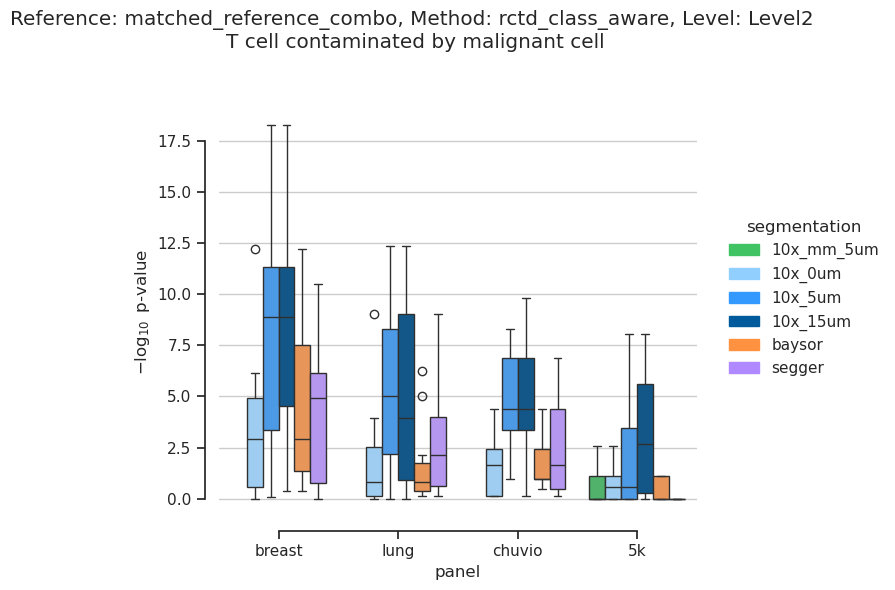

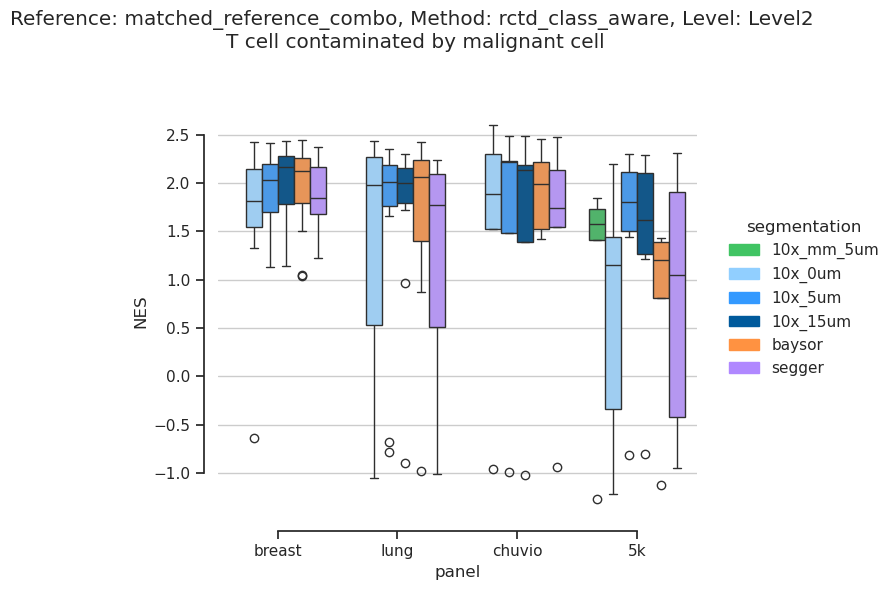

In [103]:
cti = 'T cell'
ctj = 'malignant cell'
xenium_levels = ["segmentation", "condition", "panel", "donor", "sample","cti","ctj"]

df = pd.concat(df_markers_rank_significance_diffexpr).reset_index()
df.columns = xenium_levels + df.columns[len(xenium_levels) :].tolist()
df = df.query("cti == @cti and ctj == @ctj")
df['-log10pvalue'] = -np.log10(df['hypergeometric_pvalue'])


std_seurat_analysis_dir = Path(cfg['xenium_std_seurat_analysis_dir'])
cell_type_annotation_dir = Path(cfg['xenium_cell_type_annotation_dir'])
results_dir = Path(cfg['results_dir'])
palette_dir = Path(cfg['xenium_metadata_dir'])
segmentation_palette = palette_dir / 'col_palette_segmentation.csv'

hue = "segmentation"
hue_order = [
    "10x_mm_0um",
    "10x_mm_5um",
    "10x_mm_15um",
    "10x_0um",
    "10x_5um",
    "10x_15um",
    "baysor",
    "proseg_expected",
    "proseg_mode",
    "segger",
]


palette = pd.read_csv(segmentation_palette, index_col=0).iloc[:, 0]


# plotting params, palette
title = f"Reference: {reference}, Method: {method}, Level: {level} \n{cti} contaminated by {ctj}"
unique_labels = [c for c in hue_order if c in np.unique(df[hue].dropna())]
unique_labels = unique_labels + [c for c in np.unique(df[hue].dropna()) if c not in unique_labels]
palette = {u: palette[u] for u in unique_labels}
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]

# Create joint boxplot
sns.set(style="ticks")
f = plt.figure(figsize=(6, 6))
ax = plt.subplot()
g = sns.boxplot(df,x='panel',y='-log10pvalue', 
                hue=hue, hue_order=unique_labels, 
                legend=False, palette=palette,ax=ax
                )

plt.ylabel(r'$-\log_{10} \text{ p-value}$')
sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)

plt.suptitle(title)
f.legend(
    handles=legend_handles,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    title=hue,
    frameon=False,
)
plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig(out_file, dpi=dpi, bbox_inches="tight")
plt.show()



f = plt.figure(figsize=(6, 6))
ax = plt.subplot()
g = sns.boxplot(df,x='panel',y='NES', 
                hue=hue, hue_order=unique_labels, 
                legend=False, palette=palette,ax=ax
                )

sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)

plt.suptitle(title)
f.legend(
    handles=legend_handles,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    title=hue,
    frameon=False,
)
plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig(out_file, dpi=dpi, bbox_inches="tight")
plt.show()

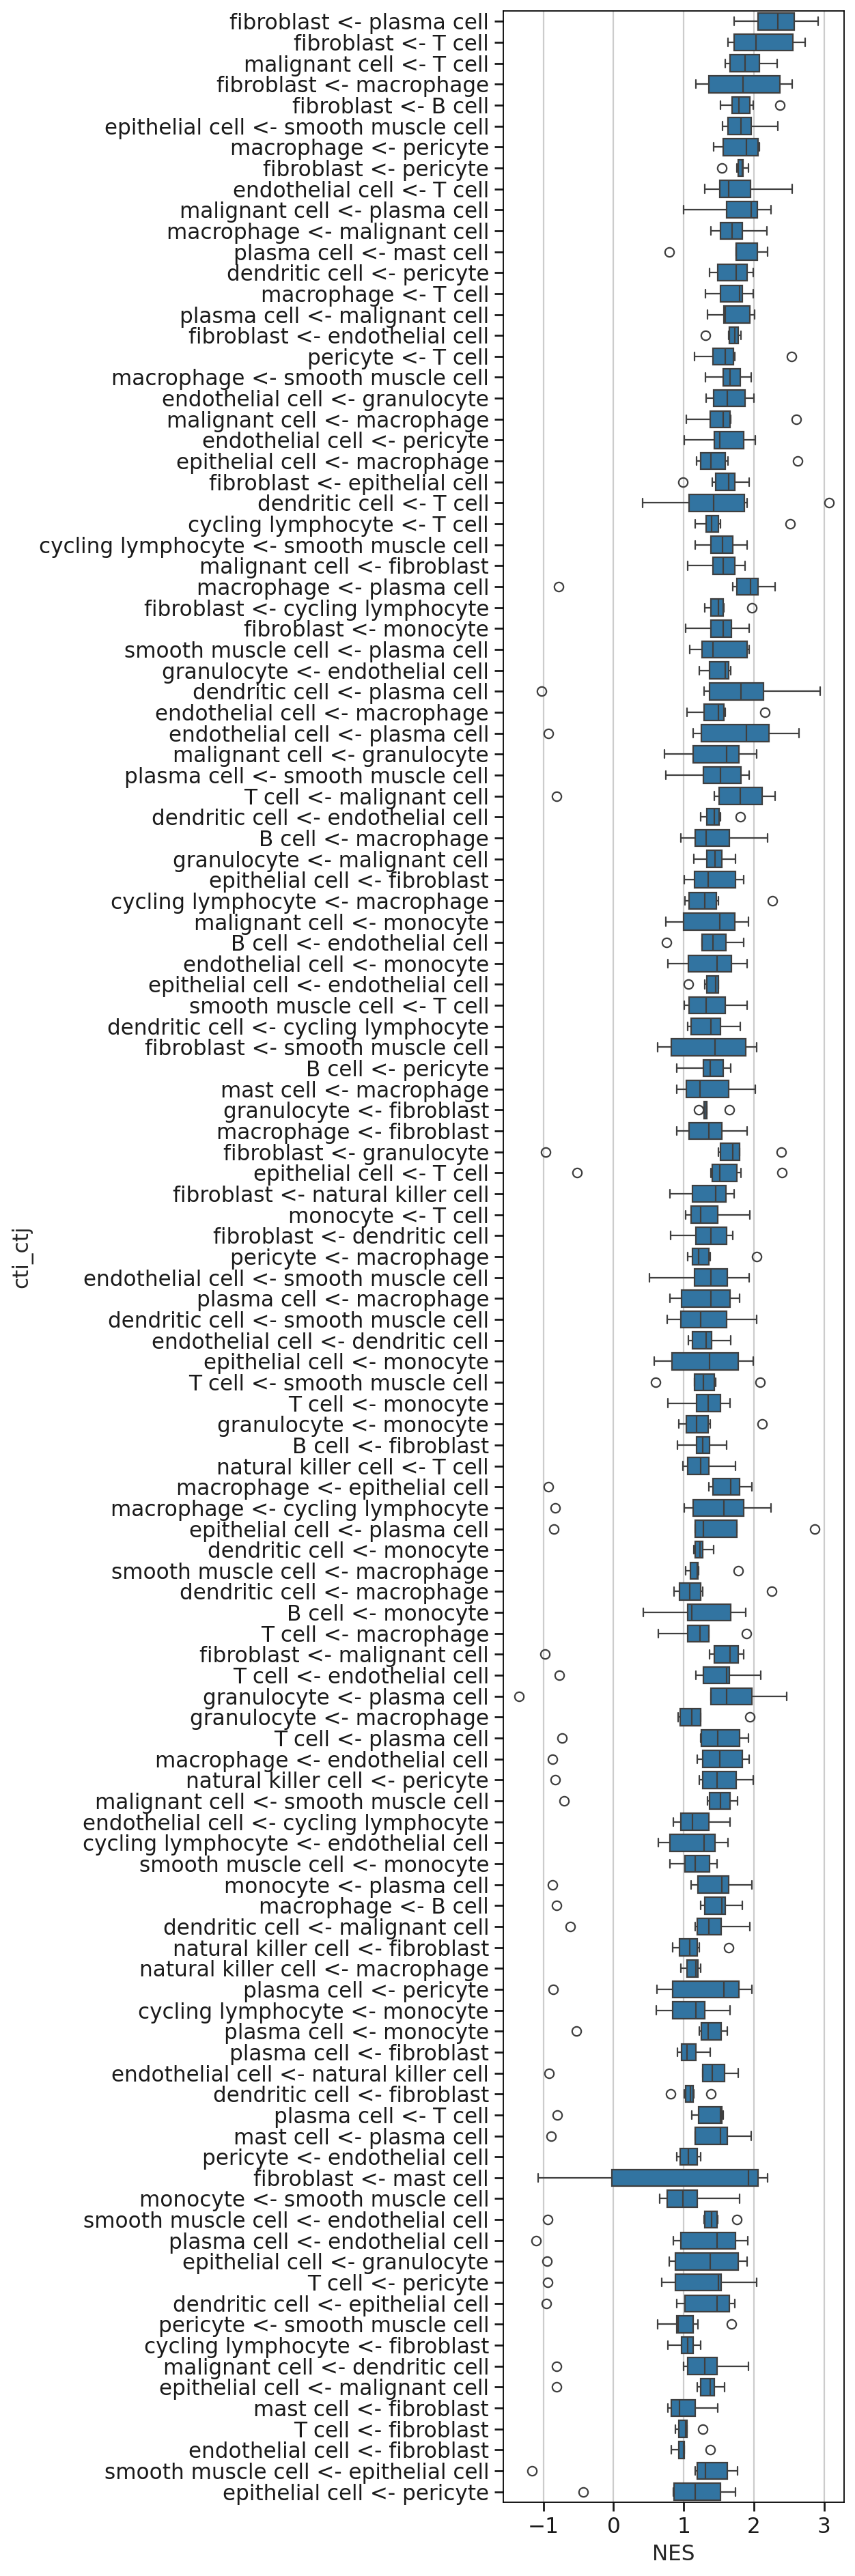

In [ ]:
plot_condition = condition.stem
plot_panel = panel.stem
threshold = 1

df = pd.concat(df_markers_rank_significance_diffexpr).reset_index()
df.columns = xenium_levels + df.columns[len(xenium_levels) :].tolist()
df = df.query(f"segmentation == '10x_5um' and condition == '{plot_condition}' and panel == '{plot_panel}'")
df['cti_ctj'] = df['cti']+' <- '+df['ctj']


# sort based on means
mean_nes_by_cti_ctj = df.groupby('cti_ctj')['NES'].mean().sort_values(ascending=False)
cti_ctj_to_keep = mean_nes_by_cti_ctj[mean_nes_by_cti_ctj >= threshold].index

df['cti_ctj'] = pd.Categorical(df['cti_ctj'], categories=mean_nes_by_cti_ctj.index, ordered=True)
df = df[df['cti_ctj'].isin(cti_ctj_to_keep)]
df['cti_ctj'] = df['cti_ctj'].cat.remove_unused_categories()
df = df.sort_values('cti_ctj')

f = plt.figure(figsize=(4, 30))
ax = plt.subplot()
g = sns.boxplot(df,y='cti_ctj',x='NES',ax=ax,orient='h')
# df = df.groupby(['cti', 'ctj'])['NES'].mean().unstack().replace(np.nan,0)
# sns.clustermap(df)

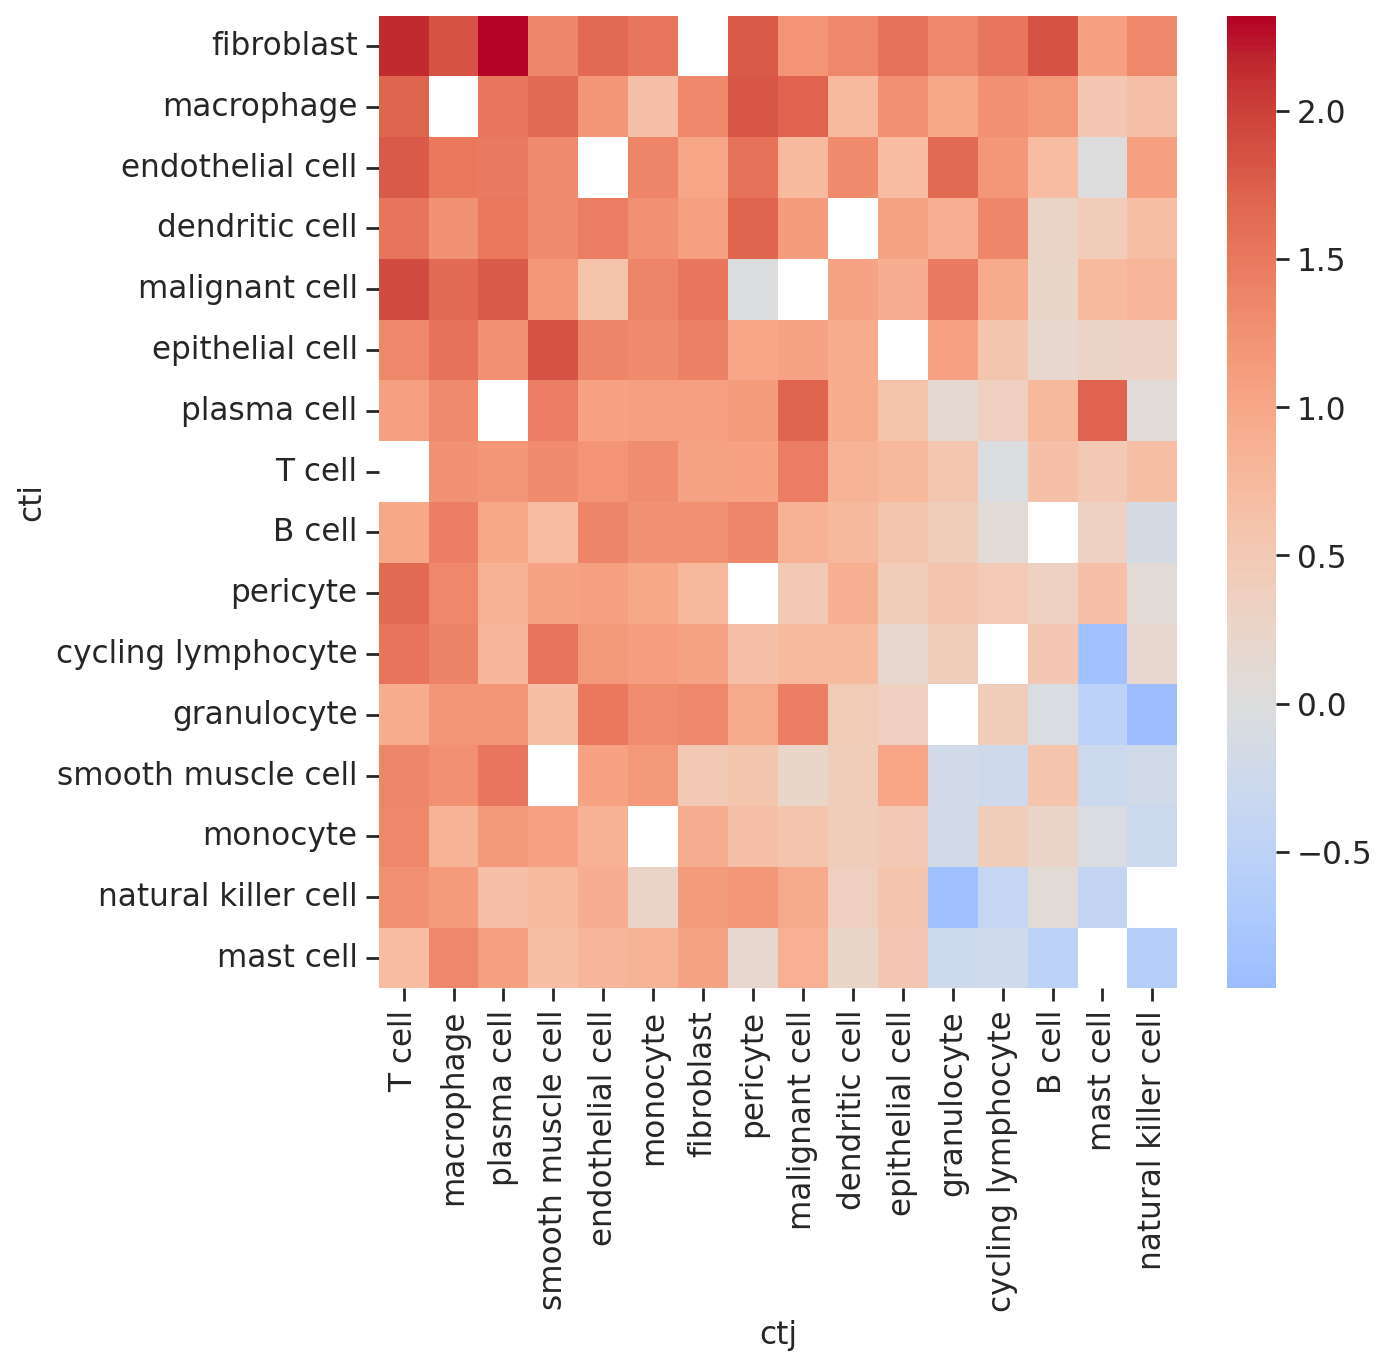

In [194]:
plot_condition = condition.stem
plot_panel = panel.stem

df = pd.concat(df_markers_rank_significance_diffexpr).reset_index()
df.columns = xenium_levels + df.columns[len(xenium_levels) :].tolist()
df = df.query(f"segmentation == '10x_5um' and condition == '{plot_condition}' and panel == '{plot_panel}'")
df = df.groupby(['cti', 'ctj'])['NES'].mean().unstack()
df = df.loc[df.sum(1).sort_values(ascending=False).index]
df = df[df.sum(0).sort_values(ascending=False).index]

sns.set_style('ticks')
f = plt.figure(figsize=(8,8))
ax = plt.subplot()
g = sns.heatmap(df,cmap='coolwarm',center=0)

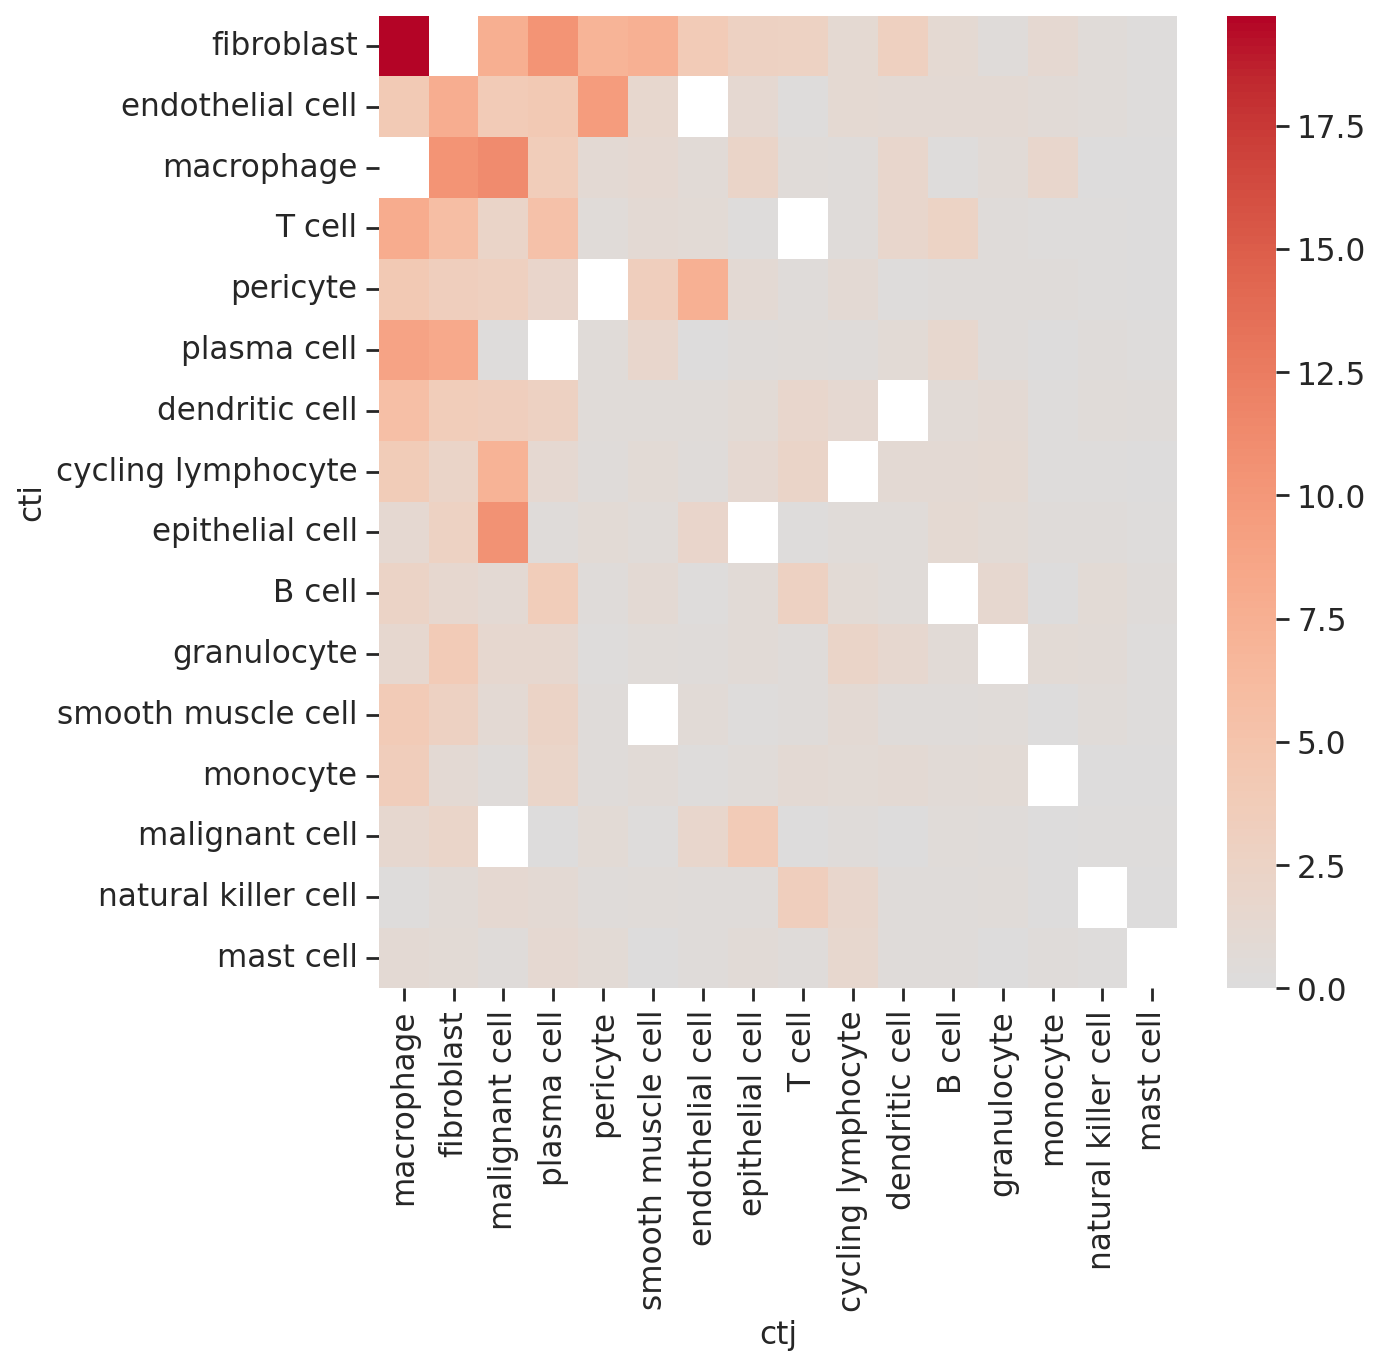

In [203]:
plot_condition = condition.stem
plot_panel = panel.stem

df = pd.concat(df_markers_rank_significance_diffexpr).reset_index()
df['-log10pvalue'] = -np.log10(df['hypergeometric_pvalue'])
df.columns = xenium_levels + df.columns[len(xenium_levels) :].tolist()
df = df.query(f"segmentation == '10x_5um' and condition == '{plot_condition}' and panel == '{plot_panel}'")
df = df.groupby(['cti', 'ctj'])['-log10pvalue'].mean().unstack()
df = df.loc[df.sum(1).sort_values(ascending=False).index]
df = df[df.sum(0).sort_values(ascending=False).index]

sns.set_style('ticks')
f = plt.figure(figsize=(8,8))
ax = plt.subplot()
g = sns.heatmap(df,cmap='coolwarm',center=0)